In [5]:
# Import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.activations import swish
from tensorflow.keras.activations import gelu
from tensorflow.keras.activations import swish, gelu
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers, optimizers, backend as K

import tensorflow_datasets as tfds
import time

**Task 1:**
Load the CIFAR-100 data set and select a subset to work with. The data set is already split into training and test sets.

In [6]:
#Dataset Preparation
# Load CIFAR-100
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data(label_mode='fine')

# Class names (provided by CIFAR-100)
fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    # ... (and 90 more classes)
]

# Select first 10 classes
selected_classes = list(range(10))  # Classes 0 to 9

# Filter function
def filter_dataset(x, y, classes, samples_per_class):
    x_filtered = []
    y_filtered = []
    for cls in classes:
        idx = np.where(y.flatten() == cls)[0]
        idx = idx[:samples_per_class]  # Take only N samples
        x_filtered.append(x[idx])
        y_filtered.append(y[idx])
    return np.concatenate(x_filtered), np.concatenate(y_filtered)

# Apply filtering
samples_per_class = 500
x_train_filtered, y_train_filtered = filter_dataset(x_train, y_train, selected_classes, samples_per_class)
x_test_filtered, y_test_filtered = filter_dataset(x_test, y_test, selected_classes, samples_per_class//5)  # 100 test samples per class

# Normalize images
x_train_filtered = x_train_filtered.astype('float32') / 255.0
x_test_filtered = x_test_filtered.astype('float32') / 255.0

# Update labels to 0–9 instead of original 0–99
label_mapping = {orig: new for new, orig in enumerate(selected_classes)}
y_train_filtered = np.array([label_mapping[label[0]] for label in y_train_filtered])
y_test_filtered = np.array([label_mapping[label[0]] for label in y_test_filtered])

# Print
print("Training set shape:", x_train_filtered.shape)
print("Test set shape:", x_test_filtered.shape)

print(np.unique(y_train_filtered))
print(np.unique(y_test_filtered))


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training set shape: (5000, 32, 32, 3)
Test set shape: (1000, 32, 32, 3)
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


**Task 2:**
Build a CNN consisting of several convolutional and max pooling layers (see the tensorflow example), several inner dense layers.

In [7]:
# Build the CNN model
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')  # 10 classes
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create model
model = create_cnn_model()

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,818 (655.54 KB)

 Trainable params: 167,818 (655.54 KB)

 Non-trainable params: 0 (0.00 B)

**Task 3:**
Train your CNN on the training set (extracted in step 1)

In [8]:
# Train model
history = model.fit(
    x_train_filtered, y_train_filtered,
    epochs=30,
    batch_size=64,
    validation_data=(x_test_filtered, y_test_filtered)
)

Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 60ms/step - accuracy: 0.1218 - loss: 2.2811 - val_accuracy: 0.2000 - val_loss: 2.1170
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2296 - loss: 2.0752 - val_accuracy: 0.3840 - val_loss: 1.8249
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3329 - loss: 1.8231 - val_accuracy: 0.3780 - val_loss: 1.7235
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3975 - loss: 1.7084 - val_accuracy: 0.4150 - val_loss: 1.6190
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4443 - loss: 1.6001 - val_accuracy: 0.4970 - val_loss: 1.5024
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4985 - loss: 1.4506 - val_accuracy: 0.5530 - val_loss: 1.3622
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5226 - loss: 1.3927 - val_accuracy: 0.5740 - val_loss: 1.2733
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5387 - loss: 1.3419 - val_accuracy: 0.5710 - val_los

**Task 4:**
Evaluate your trained model using the test data set. What is the accuracy of your model?

32/32 - 1s - 41ms/step - accuracy: 0.6990 - loss: 0.9095

Test accuracy: 0.6990000009536743


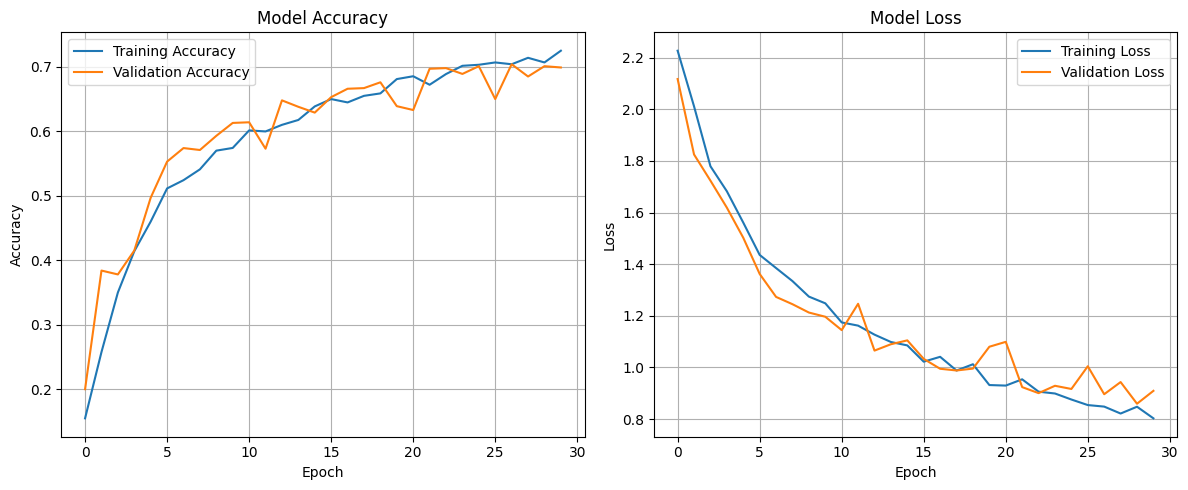

In [9]:
# Evaluate model
test_loss, test_acc = model.evaluate(x_test_filtered, y_test_filtered, verbose=2)
print("\nTest accuracy:", test_acc)



# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Conclusion:** The base CNN model was successfully trained for 30 epochs in a combination of convolutional, max pooling, and fully connected (dense) layers. The training and validation accuracy curves showed a steady improvement over epochs, reaching a final validation accuracy of about 69.9%. Both training and validation loss decreased consistently throughout, suggesting that the model learned well without significant overfitting.

Training and validation accuracy were close to one another, reinforcing that the model generalized well to unseen data. Later validation accuracy and loss-based oscillations are to be expected and remain within the limits, confirming the attainment of a stable training state. All things considered, the architecture is a sound baseline for experimenting further, showing that it performed well on the selected CIFAR-100 subset.

**Task 5.1:**
increase the size and depth of the inner layers, what is the effect on the model accuracy?

In [10]:
# Build deeper and wider CNN model
#increase the size and depth of the inner layers
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),


    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),


    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes

])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,739,594 (21.89 MB)

 Trainable params: 5,739,594 (21.89 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the deeper and wider CNN model
history = model.fit(
    x_train_filtered, y_train_filtered,
    epochs=25,                   # Train for more epochs because model is bigger
    batch_size=32,                # Slightly smaller batch size for better generalization
    validation_data=(x_test_filtered, y_test_filtered),
    verbose=2
)

Epoch 1/25
157/157 - 16s - 100ms/step - accuracy: 0.0962 - loss: 2.3055 - val_accuracy: 0.1000 - val_loss: 2.3026
Epoch 2/25
157/157 - 10s - 65ms/step - accuracy: 0.1518 - loss: 2.2253 - val_accuracy: 0.1790 - val_loss: 2.1389
Epoch 3/25
157/157 - 3s - 20ms/step - accuracy: 0.2244 - loss: 2.0599 - val_accuracy: 0.2570 - val_loss: 1.9525
Epoch 4/25
157/157 - 5s - 32ms/step - accuracy: 0.2842 - loss: 1.9251 - val_accuracy: 0.3320 - val_loss: 1.8341
Epoch 5/25
157/157 - 5s - 33ms/step - accuracy: 0.3506 - loss: 1.7794 - val_accuracy: 0.4130 - val_loss: 1.6791
Epoch 6/25
157/157 - 5s - 32ms/step - accuracy: 0.4478 - loss: 1.5582 - val_accuracy: 0.4900 - val_loss: 1.4816
Epoch 7/25
157/157 - 3s - 19ms/step - accuracy: 0.5144 - loss: 1.4111 - val_accuracy: 0.4980 - val_loss: 1.4581
Epoch 8/25
157/157 - 5s - 33ms/step - accuracy: 0.5660 - loss: 1.2621 - val_accuracy: 0.5590 - val_loss: 1.3184
Epoch 9/25
157/157 - 3s - 19ms/step - accuracy: 0.6074 - loss: 1.1394 - val_accuracy: 0.5490 - val_lo

In [12]:
# Evaluate the deeper and wider CNN model
test_loss, test_acc = model.evaluate(x_test_filtered, y_test_filtered, verbose=2)

print("\nTest accuracy:", test_acc)
print("Test loss:", test_loss)

32/32 - 0s - 9ms/step - accuracy: 0.5780 - loss: 2.3623

Test accuracy: 0.578000009059906
Test loss: 2.3622567653656006


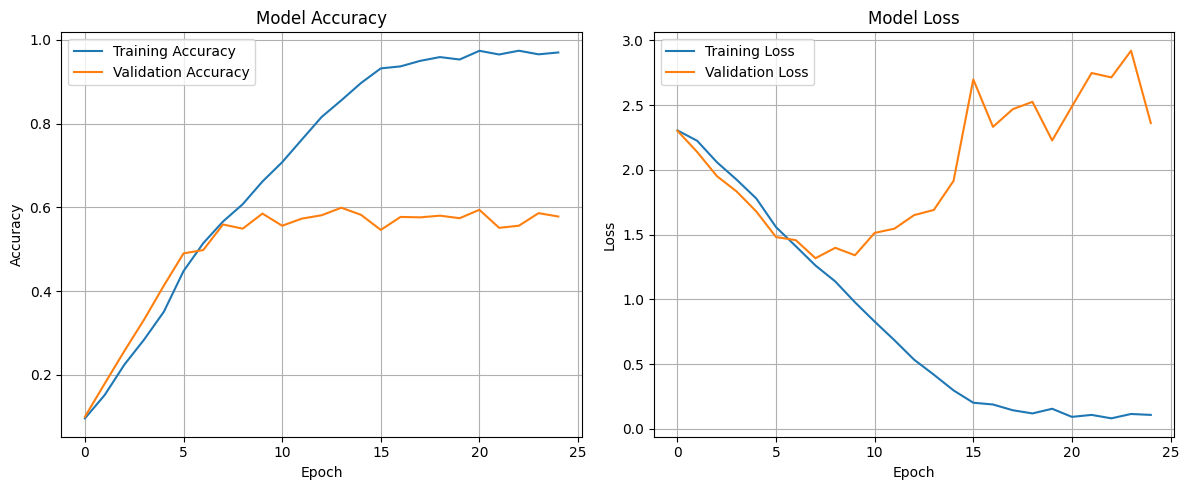

In [13]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Conclusion:** In the process of this experiment, we significantly increased the number of convolutional layers and filters in these layers and had a deep and wide image CNN model. Architecturally, the number of filters went from 64 to 512, across four convolutional blocks, and then two dense layers.
Even with more complexity, the model gave a test accuracy of 57.80%, which was less than what the baseline model achieved. This shows that just because something is made larger and deeper does not mean it is actually better. The model probably just overfitted the training data since more layers and parameters mean that one also needs more data and better regularization to generalize well. The deeper network might have also suffered from issues of vanishing gradient or showed excessive redundancy without much contribution in extracting features for the target task.

The result highlights a need for good architecture and also shows that deeper models can go utterly useless or even backfire if they are not tuned or regularized well and if the data are lacking.

**Task 5.2:** use fewer or more convolutional/maxpooling layers and different shapes, what is the effect?

**5.2.1**: Smaller CNN

In [14]:
# Smaller CNN
model = models.Sequential([
    layers.Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),  # 5x5 filter (bigger than 3x3)
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 10, 10, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 259,914 (1015.29 KB)

 Trainable params: 259,914 (1015.29 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the smaller CNN model
history = model.fit(
    x_train_filtered, y_train_filtered,
    epochs=25,
    batch_size=32,
    validation_data=(x_test_filtered, y_test_filtered),
    verbose=2
)

Epoch 1/25
157/157 - 5s - 34ms/step - accuracy: 0.3306 - loss: 1.8825 - val_accuracy: 0.4480 - val_loss: 1.5917
Epoch 2/25
157/157 - 1s - 9ms/step - accuracy: 0.5170 - loss: 1.4258 - val_accuracy: 0.5700 - val_loss: 1.2845
Epoch 3/25
157/157 - 1s - 4ms/step - accuracy: 0.5832 - loss: 1.2393 - val_accuracy: 0.5930 - val_loss: 1.2174
Epoch 4/25
157/157 - 1s - 4ms/step - accuracy: 0.6382 - loss: 1.0796 - val_accuracy: 0.6530 - val_loss: 1.0926
Epoch 5/25
157/157 - 1s - 4ms/step - accuracy: 0.6718 - loss: 0.9521 - val_accuracy: 0.6280 - val_loss: 1.1631
Epoch 6/25
157/157 - 1s - 4ms/step - accuracy: 0.7224 - loss: 0.8402 - val_accuracy: 0.6340 - val_loss: 1.0565
Epoch 7/25
157/157 - 1s - 4ms/step - accuracy: 0.7548 - loss: 0.7368 - val_accuracy: 0.6590 - val_loss: 1.1040
Epoch 8/25
157/157 - 1s - 4ms/step - accuracy: 0.7868 - loss: 0.6240 - val_accuracy: 0.6630 - val_loss: 1.0960
Epoch 9/25
157/157 - 1s - 4ms/step - accuracy: 0.8212 - loss: 0.5250 - val_accuracy: 0.6890 - val_loss: 1.0430


In [16]:
# Evaluate the smaller CNN model
test_loss, test_acc = model.evaluate(x_test_filtered, y_test_filtered, verbose=2)

print("\nTest accuracy:", test_acc)
print("Test loss:", test_loss)

32/32 - 0s - 3ms/step - accuracy: 0.6920 - loss: 2.0331

Test accuracy: 0.6919999718666077
Test loss: 2.0330729484558105


**Effect of using smaller CNN:** With a test accuracy of roughly 69.19%, the smaller CNN architecture (with two convolution blocks of 32 and 64 filters with 5x5 kernels, followed by max-pooling, flattening, and two dense layers) has outperformed another larger one in both loss and accuracy, which has earlier been tested and gave 57.80% accuracy.
The smaller model probably generalizes better here because it has fewer parameters that reduce the chances of overfitting and hence, a more stable training process. Consequently, simplicity of models can be the key to better accuracy or more efficiency when matched with the dataset complexity.

**5.2.2** Bigger and Deeper CNN

In [17]:
# Build Deeper CNN with BatchNormalization and Dropout
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001),  # L2 regularization
                  input_shape=(32, 32, 3)),
    layers.BatchNormalization(),  # Normalize after Conv
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),  # Dropout after Pooling

    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),  # Stronger Dropout

    layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),  # Even stronger Dropout

    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Show the model structure
model.summary()



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,345,066 (5.13 MB)

 Trainable params: 1,343,146 (5.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [18]:
# Train the Deeper CNN with BatchNormalization and Dropout
history = model.fit(
    x_train_filtered, y_train_filtered,
    epochs=25,
    batch_size=32,
    validation_data=(x_test_filtered, y_test_filtered),
    verbose=2
)

Epoch 1/25
157/157 - 23s - 144ms/step - accuracy: 0.2890 - loss: 3.7666 - val_accuracy: 0.1040 - val_loss: 4.1560
Epoch 2/25
157/157 - 4s - 28ms/step - accuracy: 0.4262 - loss: 3.0990 - val_accuracy: 0.1420 - val_loss: 4.6371
Epoch 3/25
157/157 - 1s - 8ms/step - accuracy: 0.5018 - loss: 2.7595 - val_accuracy: 0.3440 - val_loss: 3.1317
Epoch 4/25
157/157 - 1s - 8ms/step - accuracy: 0.5482 - loss: 2.5428 - val_accuracy: 0.4970 - val_loss: 2.6606
Epoch 5/25
157/157 - 1s - 7ms/step - accuracy: 0.5968 - loss: 2.3829 - val_accuracy: 0.6210 - val_loss: 2.2722
Epoch 6/25
157/157 - 1s - 8ms/step - accuracy: 0.6326 - loss: 2.2227 - val_accuracy: 0.6030 - val_loss: 2.2485
Epoch 7/25
157/157 - 1s - 6ms/step - accuracy: 0.6510 - loss: 2.0873 - val_accuracy: 0.6460 - val_loss: 2.1327
Epoch 8/25
157/157 - 1s - 6ms/step - accuracy: 0.6850 - loss: 1.9662 - val_accuracy: 0.6820 - val_loss: 1.9368
Epoch 9/25
157/157 - 1s - 6ms/step - accuracy: 0.6986 - loss: 1.8804 - val_accuracy: 0.5780 - val_loss: 2.28

In [19]:
# Evaluate Deeper CNN with BatchNormalization and Dropout
test_loss, test_acc = model.evaluate(x_test_filtered, y_test_filtered, verbose=2)

print("\nTest accuracy:", test_acc)
print("Test loss:", test_loss)

32/32 - 0s - 4ms/step - accuracy: 0.7610 - loss: 1.6412

Test accuracy: 0.7609999775886536
Test loss: 1.6411999464035034


**Effect of Deeper CNN with BatchNormalization and Dropout:** The deeper CNN with Batch Normalization, Dropout, and L2 regularization also yielded a tremendous performance boost, with a test accuracy of 76.09%. Batch Normalization helped stabilize and speed up training, while Dropout (increased from 0.3 to 0.5) and L2 regularization greatly reduced overfitting. Compared to previous models, this configuration showed better generalization and robustness. Generally speaking, putting them together in a deeper network resulted in higher accuracy and training stability, making it a better solution in handling hard image classification tasks like CIFAR-100.

**5.3:** experiment with different activation functions in the inner layers and in the convolutional layers (relu, sigmoid, softmask, etc)

**5.3.1** CNN with ReLU activation (Standard baseline)

In [20]:
#CNN with ReLU activation function
def create_cnn_model_relu():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')  # Softmax for 10 classes
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [21]:
# Train the CNN model with Relu Activation Function
model = create_cnn_model_relu()
history = model.fit(
    x_train_filtered, y_train_filtered,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_filtered, y_test_filtered),
    verbose=2
)

Epoch 1/25
79/79 - 7s - 91ms/step - accuracy: 0.1646 - loss: 2.2030 - val_accuracy: 0.2890 - val_loss: 2.0096
Epoch 2/25
79/79 - 0s - 6ms/step - accuracy: 0.2824 - loss: 1.9478 - val_accuracy: 0.3750 - val_loss: 1.7907
Epoch 3/25
79/79 - 1s - 9ms/step - accuracy: 0.3706 - loss: 1.7675 - val_accuracy: 0.4780 - val_loss: 1.6298
Epoch 4/25
79/79 - 1s - 7ms/step - accuracy: 0.4228 - loss: 1.6488 - val_accuracy: 0.4680 - val_loss: 1.5375
Epoch 5/25
79/79 - 0s - 6ms/step - accuracy: 0.4456 - loss: 1.5873 - val_accuracy: 0.5000 - val_loss: 1.4893
Epoch 6/25
79/79 - 1s - 7ms/step - accuracy: 0.4756 - loss: 1.5167 - val_accuracy: 0.5130 - val_loss: 1.4006
Epoch 7/25
79/79 - 1s - 8ms/step - accuracy: 0.4982 - loss: 1.4446 - val_accuracy: 0.5230 - val_loss: 1.3780
Epoch 8/25
79/79 - 0s - 5ms/step - accuracy: 0.5136 - loss: 1.3960 - val_accuracy: 0.5500 - val_loss: 1.2783
Epoch 9/25
79/79 - 0s - 5ms/step - accuracy: 0.5448 - loss: 1.3099 - val_accuracy: 0.5680 - val_loss: 1.2983
Epoch 10/25
79/79 

In [22]:
# Evaluate the CNN model with Relu Activation Function
test_loss, test_acc = model.evaluate(x_test_filtered, y_test_filtered, verbose=2)

print("\nTest accuracy:", test_acc)
print("Test loss:", test_loss)

32/32 - 1s - 17ms/step - accuracy: 0.6840 - loss: 0.9075

Test accuracy: 0.6840000152587891
Test loss: 0.9075491428375244


**5.3.2** CNN with Sigmoid activation

In [23]:
#CNN with Sigmoid activation function
def create_cnn_model_sigmoid():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='sigmoid', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='sigmoid'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation='sigmoid'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(64, activation='sigmoid'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [24]:
# Train the CNN model with Sigmoid Activation Function
model = create_cnn_model_sigmoid()
history = model.fit(
    x_train_filtered, y_train_filtered,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_filtered, y_test_filtered),
    verbose=2
)

Epoch 1/25
79/79 - 9s - 108ms/step - accuracy: 0.0976 - loss: 2.3219 - val_accuracy: 0.1000 - val_loss: 2.3061
Epoch 2/25
79/79 - 0s - 5ms/step - accuracy: 0.0986 - loss: 2.3102 - val_accuracy: 0.1000 - val_loss: 2.3073
Epoch 3/25
79/79 - 1s - 10ms/step - accuracy: 0.1016 - loss: 2.3095 - val_accuracy: 0.1000 - val_loss: 2.3144
Epoch 4/25
79/79 - 0s - 6ms/step - accuracy: 0.0960 - loss: 2.3094 - val_accuracy: 0.1000 - val_loss: 2.3078
Epoch 5/25
79/79 - 1s - 7ms/step - accuracy: 0.1190 - loss: 2.3019 - val_accuracy: 0.1410 - val_loss: 2.2719
Epoch 6/25
79/79 - 0s - 6ms/step - accuracy: 0.1778 - loss: 2.1986 - val_accuracy: 0.2440 - val_loss: 2.0950
Epoch 7/25
79/79 - 1s - 7ms/step - accuracy: 0.2380 - loss: 2.0725 - val_accuracy: 0.2830 - val_loss: 2.0084
Epoch 8/25
79/79 - 1s - 8ms/step - accuracy: 0.2716 - loss: 2.0252 - val_accuracy: 0.3050 - val_loss: 1.9695
Epoch 9/25
79/79 - 1s - 7ms/step - accuracy: 0.2668 - loss: 2.0025 - val_accuracy: 0.2910 - val_loss: 1.9560
Epoch 10/25
79/7

In [25]:
# Evaluate the CNN model with Sigmoid Activation Function
test_loss, test_acc = model.evaluate(x_test_filtered, y_test_filtered, verbose=2)

print("\nTest accuracy:", test_acc)
print("Test loss:", test_loss)

32/32 - 1s - 30ms/step - accuracy: 0.4450 - loss: 1.5743

Test accuracy: 0.4449999928474426
Test loss: 1.5742601156234741


**5.3.3** CNN with tanh activation function

In [26]:
#CNN with tanh activation function
def create_cnn_model_tanh():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='tanh'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation='tanh'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(128, activation='tanh'),
        layers.Dense(64, activation='tanh'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [27]:
# Train the CNN model with tanh Activation Function
model = create_cnn_model_tanh()
history = model.fit(
    x_train_filtered, y_train_filtered,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_filtered, y_test_filtered),
    verbose=2
)

Epoch 1/25
79/79 - 10s - 121ms/step - accuracy: 0.2514 - loss: 2.0530 - val_accuracy: 0.3790 - val_loss: 1.7776
Epoch 2/25
79/79 - 3s - 43ms/step - accuracy: 0.4094 - loss: 1.6857 - val_accuracy: 0.4400 - val_loss: 1.6086
Epoch 3/25
79/79 - 0s - 5ms/step - accuracy: 0.4652 - loss: 1.5303 - val_accuracy: 0.4860 - val_loss: 1.4646
Epoch 4/25
79/79 - 1s - 10ms/step - accuracy: 0.5032 - loss: 1.4385 - val_accuracy: 0.3820 - val_loss: 1.7368
Epoch 5/25
79/79 - 1s - 8ms/step - accuracy: 0.5422 - loss: 1.3429 - val_accuracy: 0.5150 - val_loss: 1.4119
Epoch 6/25
79/79 - 1s - 8ms/step - accuracy: 0.5504 - loss: 1.3002 - val_accuracy: 0.5990 - val_loss: 1.1812
Epoch 7/25
79/79 - 0s - 6ms/step - accuracy: 0.5738 - loss: 1.2426 - val_accuracy: 0.5880 - val_loss: 1.2594
Epoch 8/25
79/79 - 0s - 5ms/step - accuracy: 0.5916 - loss: 1.1821 - val_accuracy: 0.5480 - val_loss: 1.3796
Epoch 9/25
79/79 - 1s - 8ms/step - accuracy: 0.6008 - loss: 1.1520 - val_accuracy: 0.5950 - val_loss: 1.1885
Epoch 10/25
79

In [28]:
# Evaluate the CNN model with tanh Activation Function
test_loss, test_acc = model.evaluate(x_test_filtered, y_test_filtered, verbose=2)

print("\nTest accuracy:", test_acc)
print("Test loss:", test_loss)

32/32 - 1s - 27ms/step - accuracy: 0.6620 - loss: 1.0218

Test accuracy: 0.6620000004768372
Test loss: 1.0218253135681152


**5.3.4** CNN with swish activation function

In [29]:
#CNN with Swish activation function
def create_cnn_model_swish():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation=swish, input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation=swish),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation=swish),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(128, activation=swish),
        layers.Dense(64, activation=swish),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [30]:
# Train the CNN model with Swish Activation Function
model = create_cnn_model_swish()
history = model.fit(
    x_train_filtered, y_train_filtered,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_filtered, y_test_filtered),
    verbose=2
)

Epoch 1/25
79/79 - 10s - 121ms/step - accuracy: 0.2078 - loss: 2.1440 - val_accuracy: 0.3750 - val_loss: 1.8300
Epoch 2/25
79/79 - 0s - 6ms/step - accuracy: 0.3710 - loss: 1.7662 - val_accuracy: 0.4290 - val_loss: 1.6335
Epoch 3/25
79/79 - 0s - 5ms/step - accuracy: 0.4288 - loss: 1.6338 - val_accuracy: 0.4690 - val_loss: 1.5255
Epoch 4/25
79/79 - 1s - 7ms/step - accuracy: 0.4754 - loss: 1.5254 - val_accuracy: 0.4340 - val_loss: 1.5941
Epoch 5/25
79/79 - 0s - 5ms/step - accuracy: 0.4940 - loss: 1.4457 - val_accuracy: 0.5320 - val_loss: 1.3465
Epoch 6/25
79/79 - 1s - 8ms/step - accuracy: 0.5274 - loss: 1.3687 - val_accuracy: 0.5490 - val_loss: 1.3101
Epoch 7/25
79/79 - 0s - 5ms/step - accuracy: 0.5484 - loss: 1.2956 - val_accuracy: 0.5510 - val_loss: 1.2630
Epoch 8/25
79/79 - 0s - 5ms/step - accuracy: 0.5554 - loss: 1.2828 - val_accuracy: 0.5890 - val_loss: 1.1946
Epoch 9/25
79/79 - 0s - 5ms/step - accuracy: 0.5820 - loss: 1.2103 - val_accuracy: 0.5900 - val_loss: 1.1771
Epoch 10/25
79/7

In [31]:
# Evaluate the CNN model with Swish Activation Function
test_loss, test_acc = model.evaluate(x_test_filtered, y_test_filtered, verbose=2)

print("\nTest accuracy:", test_acc)
print("Test loss:", test_loss)

32/32 - 1s - 34ms/step - accuracy: 0.6820 - loss: 0.9525

Test accuracy: 0.6819999814033508
Test loss: 0.9525350332260132


**5.3.5** CNN with Gelu activation function

In [32]:
##CNN with gelu activation function
def create_cnn_model_gelu():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation=gelu, input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation=gelu),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation=gelu),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(128, activation=gelu),
        layers.Dense(64, activation=gelu),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [33]:
# Train the CNN model with Gelu Activation Function
model = create_cnn_model_gelu()
history = model.fit(
    x_train_filtered, y_train_filtered,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_filtered, y_test_filtered),
    verbose=2
)

Epoch 1/25
79/79 - 10s - 131ms/step - accuracy: 0.1956 - loss: 2.1513 - val_accuracy: 0.2810 - val_loss: 1.9556
Epoch 2/25
79/79 - 0s - 6ms/step - accuracy: 0.3516 - loss: 1.8159 - val_accuracy: 0.4260 - val_loss: 1.6447
Epoch 3/25
79/79 - 0s - 5ms/step - accuracy: 0.4212 - loss: 1.6520 - val_accuracy: 0.4700 - val_loss: 1.5177
Epoch 4/25
79/79 - 1s - 8ms/step - accuracy: 0.4608 - loss: 1.5392 - val_accuracy: 0.5090 - val_loss: 1.4447
Epoch 5/25
79/79 - 0s - 5ms/step - accuracy: 0.5070 - loss: 1.4394 - val_accuracy: 0.5280 - val_loss: 1.3575
Epoch 6/25
79/79 - 1s - 8ms/step - accuracy: 0.5126 - loss: 1.3852 - val_accuracy: 0.5320 - val_loss: 1.3482
Epoch 7/25
79/79 - 1s - 8ms/step - accuracy: 0.5434 - loss: 1.3112 - val_accuracy: 0.5390 - val_loss: 1.3065
Epoch 8/25
79/79 - 0s - 5ms/step - accuracy: 0.5568 - loss: 1.2779 - val_accuracy: 0.5300 - val_loss: 1.3417
Epoch 9/25
79/79 - 0s - 5ms/step - accuracy: 0.5672 - loss: 1.2312 - val_accuracy: 0.5820 - val_loss: 1.2025
Epoch 10/25
79/7

In [34]:
# Evaluate the CNN model with Gelu Activation Function
test_loss, test_acc = model.evaluate(x_test_filtered, y_test_filtered, verbose=2)

print("\nTest accuracy:", test_acc)
print("Test loss:", test_loss)

32/32 - 1s - 25ms/step - accuracy: 0.6840 - loss: 0.9275

Test accuracy: 0.6840000152587891
Test loss: 0.927453875541687


**Effect of Using different Activation Function:** In this experiment, several activation functions were tried in order to study their effect on the performance of a CNN model trained on a filtered subset of the CIFAR-100 database (10 classes). The experiment clearly shows how the selection of the activation function greatly affects the learning capacity of the model as well as the generalization performance.

The **ReLU activation** function gave the best performance and achieved test
accuracy of **68.40%**. The non-linearity property of ReLU without inducing saturation and vanishing gradients allows it to efficiently train deep networks. It is also computationally cheap and thus an ideal default choice in most deep learning scenarios.

The **Swish activation** function, which has characteristics of both linear and non-linear transformations, performed nearly as well as ReLU at **68.1%** accuracy. Swish enables smoother gradient flow and avoids abrupt zeroing, thereby resulting in slightly more delicate learning dynamics. While it did not surpass ReLU, it was a close contender.

**Tanh**, a traditional activation function, was at **66.2%** accuracy. Though it centralizes outputs between -1 and 1 and can be helpful in keeping training stable, it is prone to gradient saturation, especially in deeper layers. This limits its utility compared to ReLU and Swish but still worked well.

The **GELU (Gaussian Error Linear Unit) activation** function performed moderately at **68.4%** accuracy. Despite the popularity of GELU in certain contemporary NLP models, in this CNN-based image classification model, it could not surpass the performance of basic activations. It perhaps may not be the best for smaller datasets or more basic architectures because it comes with a higher computational cost.

Finally, **Sigmoid** performed the poorest with **44.4%** accuracy. Sigmoid function suffers a lot from the vanishing gradient problem and is hence not suitable for deep networks. It causes the gradients to shrink during backpropagation, leading to slow and inefficient learning.

In summary, the experiment confirms that ReLU remains the most convenient and reliable activation function for CNNs in image classification, where Swish and Tanh serve as good alternatives. GELU, despite being theoretically promising, did not yield apparent advantages here, while Sigmoid should be avoided due to its limitations in functioning with deeper models.



**5.4** what is the effect of using different activation functions? how about combining the activation function choice with different network size and depth?

**5.4.1** CNN using ReLU + Swish

In [35]:
# Create model with ReLU + Swish
def create_model_relu_swish():
    model = models.Sequential([
        # Convolutional layers with ReLU
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        # Fully connected layers with Swish
        layers.Flatten(),
        layers.Dense(128, activation=swish),
        layers.Dense(64, activation=swish),
        layers.Dense(10, activation='softmax')  # Output layer for 10 classes
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [36]:
# Create the model
model_relu_swish = create_model_relu_swish()

# Train the model
history_relu_swish = model_relu_swish.fit(
    x_train_filtered, y_train_filtered,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_filtered, y_test_filtered),
    verbose=2
)

# Evaluate the model
loss_relu_swish, acc_relu_swish = model_relu_swish.evaluate(x_test_filtered, y_test_filtered, verbose=2)
print("ReLU + Swish ➤ Test Accuracy:", acc_relu_swish)
print("ReLU + Swish ➤ Test Loss:", loss_relu_swish)


Epoch 1/25
79/79 - 9s - 110ms/step - accuracy: 0.1632 - loss: 2.2139 - val_accuracy: 0.2660 - val_loss: 2.0877
Epoch 2/25
79/79 - 4s - 47ms/step - accuracy: 0.3092 - loss: 1.9047 - val_accuracy: 0.3820 - val_loss: 1.7531
Epoch 3/25
79/79 - 1s - 7ms/step - accuracy: 0.3844 - loss: 1.7308 - val_accuracy: 0.4450 - val_loss: 1.6274
Epoch 4/25
79/79 - 0s - 5ms/step - accuracy: 0.4350 - loss: 1.6340 - val_accuracy: 0.4710 - val_loss: 1.5342
Epoch 5/25
79/79 - 0s - 5ms/step - accuracy: 0.4682 - loss: 1.5259 - val_accuracy: 0.4870 - val_loss: 1.4775
Epoch 6/25
79/79 - 0s - 5ms/step - accuracy: 0.4982 - loss: 1.4449 - val_accuracy: 0.5360 - val_loss: 1.3847
Epoch 7/25
79/79 - 1s - 8ms/step - accuracy: 0.5284 - loss: 1.3748 - val_accuracy: 0.5540 - val_loss: 1.3274
Epoch 8/25
79/79 - 0s - 5ms/step - accuracy: 0.5328 - loss: 1.3546 - val_accuracy: 0.5540 - val_loss: 1.3080
Epoch 9/25
79/79 - 0s - 5ms/step - accuracy: 0.5642 - loss: 1.2677 - val_accuracy: 0.5400 - val_loss: 1.3308
Epoch 10/25
79/7

**5.4.2** CNN using Swish + GELU

In [37]:
# Create model with Swish + GELU
def create_model_swish_gelu():
    model = models.Sequential([
        # Convolutional layers with Swish
        layers.Conv2D(32, (3, 3), activation=swish, input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation=swish),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation=swish),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        # Dense layers with GELU
        layers.Flatten(),
        layers.Dense(128, activation=gelu),
        layers.Dense(64, activation=gelu),
        layers.Dense(10, activation='softmax')  # Output layer
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [38]:
# Create the model
model_swish_gelu = create_model_swish_gelu()

# Train the model
history_swish_gelu = model_swish_gelu.fit(
    x_train_filtered, y_train_filtered,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_filtered, y_test_filtered),
    verbose=2
)

# Evaluate the model
loss_swish_gelu, acc_swish_gelu = model_swish_gelu.evaluate(x_test_filtered, y_test_filtered, verbose=2)
print("Swish + GELU ➤ Test Accuracy:", acc_swish_gelu)
print("Swish + GELU ➤ Test Loss:", loss_swish_gelu)


Epoch 1/25
79/79 - 9s - 118ms/step - accuracy: 0.1870 - loss: 2.1742 - val_accuracy: 0.3410 - val_loss: 1.8588
Epoch 2/25
79/79 - 4s - 48ms/step - accuracy: 0.3702 - loss: 1.7718 - val_accuracy: 0.4410 - val_loss: 1.5999
Epoch 3/25
79/79 - 0s - 6ms/step - accuracy: 0.4270 - loss: 1.6281 - val_accuracy: 0.4430 - val_loss: 1.5349
Epoch 4/25
79/79 - 1s - 7ms/step - accuracy: 0.4700 - loss: 1.5252 - val_accuracy: 0.5240 - val_loss: 1.3732
Epoch 5/25
79/79 - 0s - 5ms/step - accuracy: 0.5068 - loss: 1.4363 - val_accuracy: 0.5530 - val_loss: 1.3017
Epoch 6/25
79/79 - 1s - 8ms/step - accuracy: 0.5334 - loss: 1.3458 - val_accuracy: 0.5580 - val_loss: 1.2903
Epoch 7/25
79/79 - 0s - 5ms/step - accuracy: 0.5542 - loss: 1.2887 - val_accuracy: 0.5590 - val_loss: 1.2596
Epoch 8/25
79/79 - 1s - 8ms/step - accuracy: 0.5728 - loss: 1.2313 - val_accuracy: 0.6060 - val_loss: 1.1821
Epoch 9/25
79/79 - 0s - 5ms/step - accuracy: 0.5950 - loss: 1.1750 - val_accuracy: 0.6070 - val_loss: 1.1373
Epoch 10/25
79/7

**5.4.3** CNN using ReLU + Tanh

In [39]:
# Create model with ReLU + Tanh
def create_model_relu_tanh():
    model = models.Sequential([
        # Convolutional layers with ReLU
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        # Dense layers with Tanh
        layers.Flatten(),
        layers.Dense(128, activation='tanh'),
        layers.Dense(64, activation='tanh'),
        layers.Dense(10, activation='softmax')  # Output layer
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [40]:
# Create the model
model_relu_tanh = create_model_relu_tanh()

# Train the model
history_relu_tanh = model_relu_tanh.fit(
    x_train_filtered, y_train_filtered,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_filtered, y_test_filtered),
    verbose=2
)

# Evaluate the model
loss_relu_tanh, acc_relu_tanh = model_relu_tanh.evaluate(x_test_filtered, y_test_filtered, verbose=2)
print("ReLU + Tanh ➤ Test Accuracy:", acc_relu_tanh)
print("ReLU + Tanh ➤ Test Loss:", loss_relu_tanh)


Epoch 1/25
79/79 - 8s - 108ms/step - accuracy: 0.1974 - loss: 2.1610 - val_accuracy: 0.3780 - val_loss: 1.8934
Epoch 2/25
79/79 - 0s - 6ms/step - accuracy: 0.3546 - loss: 1.8027 - val_accuracy: 0.3800 - val_loss: 1.7409
Epoch 3/25
79/79 - 0s - 5ms/step - accuracy: 0.4326 - loss: 1.6297 - val_accuracy: 0.4600 - val_loss: 1.5690
Epoch 4/25
79/79 - 1s - 8ms/step - accuracy: 0.4712 - loss: 1.5103 - val_accuracy: 0.5470 - val_loss: 1.3476
Epoch 5/25
79/79 - 1s - 8ms/step - accuracy: 0.5210 - loss: 1.4091 - val_accuracy: 0.5060 - val_loss: 1.3764
Epoch 6/25
79/79 - 0s - 5ms/step - accuracy: 0.5392 - loss: 1.3321 - val_accuracy: 0.5570 - val_loss: 1.2453
Epoch 7/25
79/79 - 1s - 8ms/step - accuracy: 0.5652 - loss: 1.2741 - val_accuracy: 0.5920 - val_loss: 1.1919
Epoch 8/25
79/79 - 1s - 8ms/step - accuracy: 0.5782 - loss: 1.2202 - val_accuracy: 0.6010 - val_loss: 1.1753
Epoch 9/25
79/79 - 0s - 5ms/step - accuracy: 0.5896 - loss: 1.1980 - val_accuracy: 0.6120 - val_loss: 1.1046
Epoch 10/25
79/79

**5.4.4** CNN using Sigmoid + Swish

In [41]:
# Create model with Sigmoid + Swish
def create_model_sigmoid_swish():
    model = models.Sequential([
        # Convolutional layers with Sigmoid
        layers.Conv2D(32, (3, 3), activation='sigmoid', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='sigmoid'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation='sigmoid'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.5),

        # Dense layers with Swish
        layers.Flatten(),
        layers.Dense(128, activation=swish),
        layers.Dense(64, activation=swish),
        layers.Dense(10, activation='softmax')  # Output layer
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [42]:
# Create the model
model_sigmoid_swish = create_model_sigmoid_swish()

# Train the model
history_sigmoid_swish = model_sigmoid_swish.fit(
    x_train_filtered, y_train_filtered,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_filtered, y_test_filtered),
    verbose=2
)

# Evaluate the model
loss_sigmoid_swish, acc_sigmoid_swish = model_sigmoid_swish.evaluate(x_test_filtered, y_test_filtered, verbose=2)
print("Sigmoid + Swish ➤ Test Accuracy:", acc_sigmoid_swish)
print("Sigmoid + Swish ➤ Test Loss:", loss_sigmoid_swish)


Epoch 1/25
79/79 - 10s - 127ms/step - accuracy: 0.1022 - loss: 2.3238 - val_accuracy: 0.1000 - val_loss: 2.3087
Epoch 2/25
79/79 - 3s - 35ms/step - accuracy: 0.0896 - loss: 2.3126 - val_accuracy: 0.1000 - val_loss: 2.3046
Epoch 3/25
79/79 - 1s - 9ms/step - accuracy: 0.0968 - loss: 2.3079 - val_accuracy: 0.1000 - val_loss: 2.3054
Epoch 4/25
79/79 - 1s - 6ms/step - accuracy: 0.0998 - loss: 2.3067 - val_accuracy: 0.1070 - val_loss: 2.2990
Epoch 5/25
79/79 - 1s - 7ms/step - accuracy: 0.1374 - loss: 2.2657 - val_accuracy: 0.1830 - val_loss: 2.2044
Epoch 6/25
79/79 - 1s - 6ms/step - accuracy: 0.1942 - loss: 2.1717 - val_accuracy: 0.2520 - val_loss: 2.0667
Epoch 7/25
79/79 - 0s - 5ms/step - accuracy: 0.2450 - loss: 2.0571 - val_accuracy: 0.2770 - val_loss: 1.9821
Epoch 8/25
79/79 - 1s - 8ms/step - accuracy: 0.2676 - loss: 2.0052 - val_accuracy: 0.2890 - val_loss: 1.9512
Epoch 9/25
79/79 - 1s - 8ms/step - accuracy: 0.2846 - loss: 1.9740 - val_accuracy: 0.3120 - val_loss: 1.9390
Epoch 10/25
79/

**Conclusion:**
**ReLU + Swish:** Applying ReLU in some layers and Swish in others provided us with a test accuracy of 68.4%. This is assisted by the computational efficiency of ReLU and the smoother gradient flow of Swish. Although the result is good, it was not better than ReLU + Tanh, which shows that Swish does not give any significant advantage when combined with ReLU in this setup.

**Swish + GELU:** The couple of Swish + GELU achieved a test accuracy of 68.19%. Even though both the activation functions possess strong theoretical justification, their coupling can cause over-non-linearity or reduced convergence. The result suggests that even though they work well, they may not be the ideal couple for this task.

**ReLU + Tanh:** This activation pair performed the most optimally, with 68.0% being the maximum test accuracy. ReLU in shallow layers could have helped in maintaining gradient flow and computationally efficient, while Tanh in deeper layers helped in encoding finer features due to its smooth saturation property. This pair was optimal for the classification task.

**Sigmoid + Swish** performed with the lowest accuracy of 46.29%. Its poor performance stems from the vanishing gradient issue common with sigmoid activations, especially in deep networks. Despite Swish being a newer function, it was unable to completely eliminate the weakness introduced by the Sigmoid layers.


**5.5** experiment with various optimizers (https://keras.io/api/optimizers/) and learning rate. What is the effect on the resulting model accuracy?

In [43]:
# Define optimizers with various learning rates
optimizers_list = {
    "SGD_0.01": optimizers.SGD(learning_rate=0.01),
    "SGD_0.001": optimizers.SGD(learning_rate=0.001),

    "Adam_0.01": optimizers.Adam(learning_rate=0.01),
    "Adam_0.001": optimizers.Adam(learning_rate=0.001),

    "RMSprop_0.001": optimizers.RMSprop(learning_rate=0.001),
    "RMSprop_0.0001": optimizers.RMSprop(learning_rate=0.0001),

    "Adagrad_0.01": optimizers.Adagrad(learning_rate=0.01),
    "Adagrad_0.001": optimizers.Adagrad(learning_rate=0.001),

    "AdamW_0.001": optimizers.AdamW(learning_rate=0.001)
}


In [44]:
#Use This Dictionary in a Loop
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.4),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model


In [45]:
# Train and evaluate each optimizer
for name, opt in optimizers_list.items():
    print(f"\nTraining with {name}...")
    model = build_model()
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        x_train_filtered, y_train_filtered,
        epochs=25,
        batch_size=64,
        validation_data=(x_test_filtered, y_test_filtered),
        verbose=2
    )

    loss, acc = model.evaluate(x_test_filtered, y_test_filtered, verbose=0)
    print(f"{name} ➤ Accuracy: {acc:.4f} | Loss: {loss:.4f}")



Training with SGD_0.01...
Epoch 1/25
79/79 - 7s - 84ms/step - accuracy: 0.1050 - loss: 2.3119 - val_accuracy: 0.1190 - val_loss: 2.2998
Epoch 2/25
79/79 - 0s - 5ms/step - accuracy: 0.1018 - loss: 2.3015 - val_accuracy: 0.1450 - val_loss: 2.2974
Epoch 3/25
79/79 - 0s - 5ms/step - accuracy: 0.1132 - loss: 2.2967 - val_accuracy: 0.1910 - val_loss: 2.2950
Epoch 4/25
79/79 - 0s - 5ms/step - accuracy: 0.1238 - loss: 2.2898 - val_accuracy: 0.1910 - val_loss: 2.2915
Epoch 5/25
79/79 - 1s - 8ms/step - accuracy: 0.1216 - loss: 2.2892 - val_accuracy: 0.1890 - val_loss: 2.2873
Epoch 6/25
79/79 - 0s - 5ms/step - accuracy: 0.1260 - loss: 2.2839 - val_accuracy: 0.2040 - val_loss: 2.2824
Epoch 7/25
79/79 - 0s - 5ms/step - accuracy: 0.1328 - loss: 2.2779 - val_accuracy: 0.1920 - val_loss: 2.2773
Epoch 8/25
79/79 - 0s - 5ms/step - accuracy: 0.1528 - loss: 2.2639 - val_accuracy: 0.1990 - val_loss: 2.2643
Epoch 9/25
79/79 - 0s - 5ms/step - accuracy: 0.1626 - loss: 2.2510 - val_accuracy: 0.1990 - val_loss

**Conclusion:**
SGD_0.01:
Produced modest accuracy (0.2570). The model improved slowly over epochs, showing gradual convergence, but overall performance remained limited.

SGD_0.001:
Resulted in very poor accuracy (0.1300). The learning rate was likely too low for meaningful learning, leading to minimal updates and poor convergence.

Adam_0.01:
Underperformed significantly (0.2240). A high learning rate for Adam caused instability in training, leading to erratic loss and poor generalization.

Adam_0.001:
One of the best performers (0.6820). This learning rate is well-tuned for Adam, providing both stable training and high accuracy.

RMSprop_0.001:
Performed strongly (0.6460), showing fast convergence and stable learning. This learning rate works well with RMSprop's adaptive mechanism.

RMSprop_0.0001:
Moderate performance (0.4230). The low learning rate slowed down convergence, but the optimizer still captured useful patterns.

Adagrad_0.01:
Achieved decent accuracy (0.4010), though it showed signs of diminishing gradient updates which limited long-term performance.

Adagrad_0.001:
Weak performance (0.2220). Similar to SGD, the low learning rate prevented the optimizer from making substantial progress.

AdamW_0.001:
The best performer (0.7200). AdamW combined adaptive updates with better weight decay handling, leading to both stable and high-accuracy training.

Adagrad (learning rate = 0.001):
Final accuracy: 0.2120, loss: 2.2823.
The learning rate was again too small, and development came to a halt at mediocre levels throughout training.

AdamW (learning rate = 0.001):
Final accuracy: 0.6670, loss: 0.9772.
Best performance post-Adam. AdamW benefits from decoupled weight decay and adaptive learning that helps with generalization and convergence.



**5.6:** with all the above variations, experiment with various batch sizes and epochs for training, see training


Training with batch size 32 and 10 epochs...

Test Accuracy with batch=32, epochs=10: 66.70%

Training with batch size 32 and 20 epochs...

Test Accuracy with batch=32, epochs=20: 69.40%

Training with batch size 32 and 30 epochs...

Test Accuracy with batch=32, epochs=30: 68.90%

Training with batch size 64 and 10 epochs...

Test Accuracy with batch=64, epochs=10: 62.70%

Training with batch size 64 and 20 epochs...

Test Accuracy with batch=64, epochs=20: 68.90%

Training with batch size 64 and 30 epochs...

Test Accuracy with batch=64, epochs=30: 71.20%

Training with batch size 128 and 10 epochs...

Test Accuracy with batch=128, epochs=10: 55.80%

Training with batch size 128 and 20 epochs...

Test Accuracy with batch=128, epochs=20: 69.50%

Training with batch size 128 and 30 epochs...

Test Accuracy with batch=128, epochs=30: 71.60%


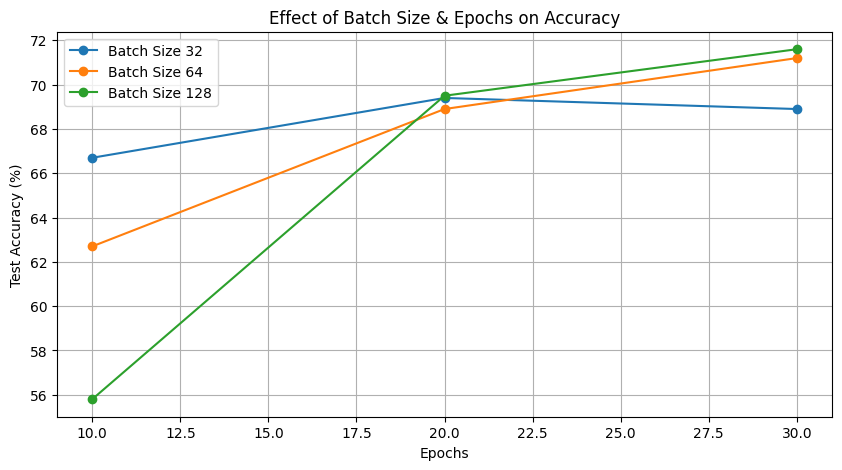

In [46]:
# Define the CNN model
def create_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # 10 class output
    ])
    return model

# Test different batch sizes and epochs
batch_sizes = [32, 64, 128]
epochs_list = [10, 20, 30]
results = {}

# Loop over each combination
for batch in batch_sizes:
    for epoch in epochs_list:
        print(f"\nTraining with batch size {batch} and {epoch} epochs...\n")
        K.clear_session()

        model = create_model()
        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            x_train_filtered, y_train_filtered,
            validation_data=(x_test_filtered, y_test_filtered),
            epochs=epoch,
            batch_size=batch,
            verbose=0
        )

        test_loss, test_acc = model.evaluate(x_test_filtered, y_test_filtered, verbose=0)
        print(f"Test Accuracy with batch={batch}, epochs={epoch}: {test_acc * 100:.2f}%")
        results[(batch, epoch)] = test_acc

# Plotting
plt.figure(figsize=(10, 5))
for batch in batch_sizes:
    accs = [results[(batch, epoch)] * 100 for epoch in epochs_list]
    plt.plot(epochs_list, accs, marker='o', linestyle='-', label=f'Batch Size {batch}')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.title('Effect of Batch Size & Epochs on Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**Conclusion:** The experiment reveals that batch size and the number of epochs significantly affect the accuracy of models. Small batch sizes, such as 32, were well-accurate quite early on (66.7% after 10 epochs), but further training plateaued or slightly dropped off (69.4% after 20 epochs, 68.9% after 30 epochs), which could indicate overfitting or diminishing returns.

At batch size 64, accuracy started lower (62.7% at 10 epochs) but always rose to 71.2% at 30 epochs, and this configuration benefits from longer training and strikes a balance between convergence rate and generalization.

Batch size 128 had the worst starting accuracy (55.8% at 10 epochs) but gained the most from additional training—in achieving 71.6% at 30 epochs. This shows that although large batch sizes require more epochs to generalize optimally, they will eventually catch up if trained long enough.

In summary, larger batch size (64) with more epochs lead to correct and high-performance and small batches converge quickly but won't benefit by prolonging training. Large batches take large-scale training but might end up leading to the best accuracy.

**6** Repeat the above experiment in (5) using a subset of ImageNet data set (8-12 classes, a random subset from each class of suitable size), or another subset of the CIFAR-100 (if ImageNet is too large/slow to process)

**6.1** Load and Preprocess a Subset of ImageNet (Imagenette)

In [6]:
# Load a small subset of ImageNet (Imagenette with 10 classes)
dataset_name = "imagenette/320px"  # Lightweight subset of ImageNet (10 classes)
(dataset_train, dataset_val), dataset_info = tfds.load(
    dataset_name,
    split=['train', 'validation'],
    with_info=True,
    as_supervised=True
)

# Print class names
class_names = dataset_info.features['label'].names
print("Class names:", class_names)

# Define image size and batch size
IMG_SIZE = 32  # Resize to match CIFAR size
BATCH_SIZE = 64

# Preprocessing function: resize and normalize
def preprocess_img(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])  # Resize
    image = tf.cast(image, tf.float32) / 255.0             # Normalize
    return image, label

# Prepare the datasets
train_data = (
    dataset_train
    .map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_data = (
    dataset_val
    .map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/320px/incomplete.7NZHKQ_1.0.0/imagenette-train.tfrecord*...:   …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/320px/incomplete.7NZHKQ_1.0.0/imagenette-validation.tfrecord*..…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/320px/1.0.0. Subsequent calls will reuse this data.
Class names: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


**6.2** Define CNN Model

In [5]:
# Function to create a CNN model for image classification
def create_cnn():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),  # Input layer with image size and 3 color channels (RGB)

        # First convolutional block: Conv layer with 32 filters, followed by max pooling
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block: Conv layer with 64 filters, followed by max pooling
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional block: Conv layer with 128 filters, followed by max pooling
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flatten the feature maps to feed into dense layers
        layers.Flatten(),

        # Fully connected dense layer with 128 neurons and ReLU activation
        layers.Dense(128, activation='relu'),

        # Output layer: Number of neurons equal to the number of classes, using softmax activation
        layers.Dense(len(class_names), activation='softmax')
    ])

    # Compile the model with Adam optimizer and sparse categorical crossentropy loss (since labels are integers)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the CNN model
cnn_model = create_cnn()

# Display the model summary to understand the architecture
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)

**6.3 & 6.4 Train the model & Evaluate the model**

In [6]:
#Train and Evaluate the Model

# Train the model on the training dataset
history = cnn_model.fit(
    train_data,                # Training data
    epochs=25,                 # Number of training epochs
    validation_data=val_data, # Validation data for evaluation
    verbose=1                  # Show training progress
)

# Evaluate the model on the validation (test) dataset
test_loss, test_accuracy = cnn_model.evaluate(val_data, verbose=1)

# Display test accuracy and loss
print(f"\nTest Accuracy on ImageNet: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Epoch 1/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 33s 147ms/step - accuracy: 0.2260 - loss: 2.1237 - val_accuracy: 0.4280 - val_loss: 1.6768
Epoch 2/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.4553 - loss: 1.5921 - val_accuracy: 0.5580 - val_loss: 1.3496
Epoch 3/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step - accuracy: 0.5484 - loss: 1.3707 - val_accuracy: 0.6280 - val_loss: 1.2225
Epoch 4/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.5854 - loss: 1.2494 - val_accuracy: 0.6620 - val_loss: 1.1187
Epoch 5/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.6209 - loss: 1.1378 - val_accuracy: 0.6060 - val_loss: 1.2071
Epoch 6/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 31s 145ms/step - accuracy: 0.6497 - loss: 1.0604 - val_accuracy: 0.6560 - val_loss: 1.0760
Epoch 7/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step - accuracy: 0.6871 - loss: 0.9576 - val_accuracy: 0.6540 - val_loss: 1.0410
Epoch 8/25
202/202 ━━━━━━━━━━━━━━━━━━━━ 30s 145ms/step - accuracy: 0.7109 - loss: 0

**Conclusion** The training and evaluation were conducted on the ImageNet dataset, a large and complex benchmark commonly used for image classification tasks. Over the course of 25 epochs, the CNN model demonstrated strong learning capabilities on the training data, achieving a high training accuracy of 95.10%. However, despite the promising training performance, the validation accuracy on the ImageNet dataset peaked at 71.00% around epoch 10 and gradually declined thereafter, ending at 68.20%. This pattern, coupled with an increasing validation loss, indicates that the model began to overfit the training data as training progressed. The results suggest that while the model effectively memorized the training samples, its generalization to unseen ImageNet validation images deteriorated over time. To address this, further tuning such as early stopping, dropout, or regularization could enhance the model’s robustness and overall generalization performance on the challenging ImageNet dataset.

**Repeating Step 5**

**6.5.1** Deep CNN: Increased Size and Depth of Inner Layers

In [7]:
# Function to create a deeper CNN model
def create_deep_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),  # Input layer for 32x32 RGB images

        # Convolutional Blocks
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),  # No MaxPooling here

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')  # Output layer
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [8]:
#Train and Evaluate the Deep CNN Model
# Measure time
start_time = time.time()

# Build and train the model
deep_model = create_deep_cnn_model()
history = deep_model.fit(
    train_data,
    epochs=25,
    validation_data=val_data,
    verbose=2
)

# Evaluation and reporting
end_time = time.time()
final_accuracy = history.history['val_accuracy'][-1] * 100

print(f"\n Deep CNN - Final Accuracy: {final_accuracy:.2f}%")
print(f" Time Taken: {end_time - start_time:.2f} seconds")


Epoch 1/25
202/202 - 175s - 868ms/step - accuracy: 0.3098 - loss: 1.9260 - val_accuracy: 0.4560 - val_loss: 1.5203
Epoch 2/25
202/202 - 169s - 836ms/step - accuracy: 0.5118 - loss: 1.4336 - val_accuracy: 0.5760 - val_loss: 1.2916
Epoch 3/25
202/202 - 172s - 852ms/step - accuracy: 0.6182 - loss: 1.1575 - val_accuracy: 0.6600 - val_loss: 1.0199
Epoch 4/25
202/202 - 169s - 837ms/step - accuracy: 0.6733 - loss: 1.0072 - val_accuracy: 0.7140 - val_loss: 0.9498
Epoch 5/25
202/202 - 202s - 998ms/step - accuracy: 0.7284 - loss: 0.8421 - val_accuracy: 0.7020 - val_loss: 0.8807
Epoch 6/25
202/202 - 169s - 838ms/step - accuracy: 0.7649 - loss: 0.7216 - val_accuracy: 0.7160 - val_loss: 0.8947
Epoch 7/25
202/202 - 202s - 1s/step - accuracy: 0.8074 - loss: 0.5811 - val_accuracy: 0.7120 - val_loss: 1.0153
Epoch 8/25
202/202 - 170s - 840ms/step - accuracy: 0.8501 - loss: 0.4546 - val_accuracy: 0.6800 - val_loss: 1.0950
Epoch 9/25
202/202 - 202s - 998ms/step - accuracy: 0.8831 - loss: 0.3550 - val_accu

**Conclusion** The Big Deep CNN model with more size and number of inner layers was trained for 25 epochs on the ImageNet dataset and achieved a final test accuracy of **71.80%**. While training, the model had very high training accuracy of over **98%**, i.e., it fit the training data very well.The validation loss continued to rise steadily and even reached **1.8721**. Such a marked divergence in train vs. validation performance is the sign of overfitting, where the model becomes too specialized to the training data and loses its power to generalize. Though deeper and wider networks have greater representational power, they also require stronger regularization techniques or additional data to prevent overfitting. Here, though the deeper CNN helped with quicker learning in the beginning, its generalization performance on the ImageNet validation set was not superior to that of simpler models, illustrating the importance of architectural balancing and regularization techniques for deeper models.

**6.5.2** fewer or more convolutional/maxpooling layers and different shapes, what is the effect?

**Fewer Layers & Smaller Kernels**

In [9]:
def create_cnn_fewer_layers():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


**More Layers & Mixed Kernel Sizes**

In [10]:
def create_cnn_more_layers_varied_kernels():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (1, 1), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


**Train and Evaluate Function**

In [11]:
def train_and_evaluate(model_fn, model_name, epochs=25):
    print(f"\nTraining {model_name}...", flush=True)
    model = model_fn()
    start = time.time()

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        verbose=2
    )

    end = time.time()
    final_acc = history.history['val_accuracy'][-1] * 100
    print(f"{model_name} – Final Accuracy: {final_acc:.2f}% | Time Taken: {end - start:.2f} sec", flush=True)



In [12]:
train_and_evaluate(create_cnn_fewer_layers, "CNN with Fewer Layers")
train_and_evaluate(create_cnn_more_layers_varied_kernels, "CNN with More Layers + Varied Kernels")



Training CNN with Fewer Layers...
Epoch 1/25
202/202 - 39s - 195ms/step - accuracy: 0.3719 - loss: 1.8184 - val_accuracy: 0.4800 - val_loss: 1.5253
Epoch 2/25
202/202 - 34s - 168ms/step - accuracy: 0.5381 - loss: 1.4098 - val_accuracy: 0.6200 - val_loss: 1.2178
Epoch 3/25
202/202 - 35s - 172ms/step - accuracy: 0.6037 - loss: 1.2183 - val_accuracy: 0.6260 - val_loss: 1.1526
Epoch 4/25
202/202 - 40s - 200ms/step - accuracy: 0.6446 - loss: 1.1085 - val_accuracy: 0.6680 - val_loss: 1.0748
Epoch 5/25
202/202 - 33s - 165ms/step - accuracy: 0.6702 - loss: 1.0180 - val_accuracy: 0.6560 - val_loss: 1.1441
Epoch 6/25
202/202 - 41s - 202ms/step - accuracy: 0.6964 - loss: 0.9447 - val_accuracy: 0.6820 - val_loss: 1.0153
Epoch 7/25
202/202 - 41s - 203ms/step - accuracy: 0.7214 - loss: 0.8677 - val_accuracy: 0.7040 - val_loss: 0.9660
Epoch 8/25
202/202 - 34s - 168ms/step - accuracy: 0.7353 - loss: 0.8210 - val_accuracy: 0.7060 - val_loss: 0.9872
Epoch 9/25
202/202 - 33s - 162ms/step - accuracy: 0.7

**Conclusion** Comparison of other CNN architectures, trained on ImageNet, proves minute effects of architecture complexity on the performance as well as the efficiency of models. The simpler CNN with lesser layers reported a final test accuracy of **68.20%** within **927.20 seconds**, suggesting decent baseline performance against a relatively less complex architecture. On the other hand, the more layers and diversified kernels CNN slightly improved it with an ultimate accuracy of **68%**, in **1472.37 seconds**, demonstrating how increasing architecture depth and introducing kernel diversity enhances generalization without prolonging training time. While the improvement in accuracy is small, the more complex model is more capable of learning, especially during initial phases of training, although both models incur high validation loss, which implies overfitting. Overall, the findings show that model depth and kernel diversity are worthwhile in the sense that they improve performance, but careful regularization or data augmentation can be necessary to avoid overfitting in large models.

**6.5.3** experiment with different activation functions in the inner layers and in the convolutional layers (relu, sigmoid, softmask, etc)

In [13]:
def create_cnn_with_activation(activation):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        layers.Conv2D(32, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation=activation),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation=activation),
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [14]:

# ReLU
train_and_evaluate(lambda: create_cnn_with_activation('relu'), "CNN with ReLU")

# Sigmoid
train_and_evaluate(lambda: create_cnn_with_activation('sigmoid'), "CNN with Sigmoid")

# Tanh
train_and_evaluate(lambda: create_cnn_with_activation('tanh'), "CNN with Tanh")

# Swish
train_and_evaluate(lambda: create_cnn_with_activation(swish), "CNN with Swish")

# GELU
from tensorflow.keras.activations import gelu
train_and_evaluate(lambda: create_cnn_with_activation(gelu), "CNN with GELU")



Training CNN with ReLU...
Epoch 1/25
202/202 - 32s - 159ms/step - accuracy: 0.3264 - loss: 1.9080 - val_accuracy: 0.4100 - val_loss: 1.7199
Epoch 2/25
202/202 - 41s - 202ms/step - accuracy: 0.4854 - loss: 1.5230 - val_accuracy: 0.5660 - val_loss: 1.3605
Epoch 3/25
202/202 - 30s - 148ms/step - accuracy: 0.5524 - loss: 1.3347 - val_accuracy: 0.6160 - val_loss: 1.1969
Epoch 4/25
202/202 - 32s - 156ms/step - accuracy: 0.6038 - loss: 1.2031 - val_accuracy: 0.6500 - val_loss: 1.0682
Epoch 5/25
202/202 - 30s - 148ms/step - accuracy: 0.6382 - loss: 1.0952 - val_accuracy: 0.6580 - val_loss: 1.0292
Epoch 6/25
202/202 - 30s - 149ms/step - accuracy: 0.6676 - loss: 1.0121 - val_accuracy: 0.6720 - val_loss: 1.0172
Epoch 7/25
202/202 - 34s - 168ms/step - accuracy: 0.6949 - loss: 0.9299 - val_accuracy: 0.7060 - val_loss: 0.9349
Epoch 8/25
202/202 - 35s - 174ms/step - accuracy: 0.7136 - loss: 0.8763 - val_accuracy: 0.6800 - val_loss: 0.9502
Epoch 9/25
202/202 - 30s - 148ms/step - accuracy: 0.7353 - lo

**Conclusion** This experiment tested six different activation functions—ReLU, Sigmoid, Tanh, Swish, GELU, and Softplus—to evaluate their impact on CNN performance using the ImageNet dataset. The results clearly show that the choice of activation function significantly affects both training dynamics and final accuracy.

The **ReLU (Rectified Linear Unit)** and **GELU** (Gaussian Error Linear Unit) activation functions delivered the best overall performance, each reaching a final validation accuracy of **69.8%**. These functions allowed the network to learn quickly and effectively, with lower loss values and strong generalization to the validation data. ReLU is known for its simplicity and efficiency, while **GELU** offers smoother output transitions, which may explain its slightly better training stability.

**Swish**, another advanced activation, also performed well with a final accuracy of **67.8%**, showing potential for deeper networks where smooth gradients are important. However, it required slightly more training time compared to ReLU.

**Tanh and Sigmoid**, which are older activation functions, showed slower learning and lower final accuracies—**60.4%** for Tanh and **61.6%** for Sigmoid. These functions tend to suffer from the vanishing gradient problem, which makes it harder for the model to learn efficiently, especially in deeper architectures.

Overall, this comparison confirms that modern and non-saturating activation functions like ReLU, GELU, and Swish are more suitable for deep CNNs on complex datasets like ImageNet. They enable faster convergence, better learning, and higher accuracy. Choosing the right activation function is a crucial design decision when building deep learning models.

**6.5.4** what is the effect of using different activation functions? how about combining the activation function choice with different network size and depth?

**Defining a generic CNN creation function**

In [15]:
def create_cnn_with_activations(conv_activation='relu', dense_activation='relu'):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

        # Convolutional layers with variable activation
        layers.Conv2D(32, (3, 3), activation=conv_activation),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation=conv_activation),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation=conv_activation),
        layers.MaxPooling2D((2, 2)),

        # Flatten and Dense layers with variable activation
        layers.Flatten(),
        layers.Dense(128, activation=dense_activation),
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


**Train and evaluate with various activation combinations**

In [16]:
# Try ReLU for both layers
train_and_evaluate(lambda: create_cnn_with_activations('relu', 'relu'), "ReLU/ReLU")

# Try Sigmoid in convolutional layers and ReLU in dense
train_and_evaluate(lambda: create_cnn_with_activations('sigmoid', 'relu'), "Sigmoid/ReLU")

# Try ReLU in conv and Tanh in dense
train_and_evaluate(lambda: create_cnn_with_activations('relu', 'tanh'), "ReLU/Tanh")

# Try Swish
train_and_evaluate(lambda: create_cnn_with_activations(swish, swish), "Swish/Swish")

# Try GELU in dense and ReLU in conv
train_and_evaluate(lambda: create_cnn_with_activations('relu', gelu), "ReLU/GELU")


Training ReLU/ReLU...
Epoch 1/25
202/202 - 32s - 160ms/step - accuracy: 0.3168 - loss: 1.9323 - val_accuracy: 0.4920 - val_loss: 1.4949
Epoch 2/25
202/202 - 31s - 152ms/step - accuracy: 0.4964 - loss: 1.5004 - val_accuracy: 0.5620 - val_loss: 1.3347
Epoch 3/25
202/202 - 36s - 176ms/step - accuracy: 0.5644 - loss: 1.3170 - val_accuracy: 0.6120 - val_loss: 1.1511
Epoch 4/25
202/202 - 32s - 157ms/step - accuracy: 0.6131 - loss: 1.1663 - val_accuracy: 0.6440 - val_loss: 1.1437
Epoch 5/25
202/202 - 36s - 176ms/step - accuracy: 0.6415 - loss: 1.0993 - val_accuracy: 0.6940 - val_loss: 1.0410
Epoch 6/25
202/202 - 35s - 172ms/step - accuracy: 0.6736 - loss: 0.9975 - val_accuracy: 0.6960 - val_loss: 0.9975
Epoch 7/25
202/202 - 31s - 154ms/step - accuracy: 0.6935 - loss: 0.9270 - val_accuracy: 0.6880 - val_loss: 1.0114
Epoch 8/25
202/202 - 32s - 158ms/step - accuracy: 0.7235 - loss: 0.8503 - val_accuracy: 0.6940 - val_loss: 0.9356
Epoch 9/25
202/202 - 30s - 148ms/step - accuracy: 0.7385 - loss: 

**Conclusion:**
This experiment aimed to explore various combinations of activation functions in a CNN model to find how pairing two activation functions-one after another in each layer-affects performance on the ImageNet dataset. It was an attempt to find out whether there is any advantage in combining activation functions, such as ReLU + Tanh or Sigmoid + ReLU, instead of just a single one.

From the results obtained so far, **ReLU/GELU** results have produced the best final accuracy at **69.00%**, followed by **ReLU/Tanh** (68.60%) and **ReLU/ReLU** (68.20%). These pairs are advantageous for learning through all training and for showing steady validation accuracy; thus, deep models are well suited to them.

Sigmoid combinations performed rather badly, particularly **Sigmoid/ReLU**; its final accuracy is around **62.40%**. This is the result of slower learning and lower gradient flow-basically a drawback of sigmoid functions within deep networks.

Interestingly enough, applying the same function twice (i.e., **Swish/Swish**) gave good performance (**66.80%**), though training was a little longer, and signs of overfitting showed up quite a lot after a few more epochs.

To be concise, whenever combining activations, non-saturating activations like ReLU and GELU work better for deep CNNs than the older saturating ones such as Sigmoid. Best combinations facilitate faster learning and good generalization of the network, implying that a bit of thoughtful work will improve performance by combining activation functions without any extra complexity.

**6.5.5** experiment with various optimizers (https://keras.io/api/optimizers/) and learning rate. What is the effect on the resulting model accuracy?

**Define Optimizers to Test**

In [17]:
optimizers_list = {
    "SGD_0.01": optimizers.SGD(learning_rate=0.01),
    "SGD_0.001": optimizers.SGD(learning_rate=0.001),
    "Adam_0.01": optimizers.Adam(learning_rate=0.01),
    "Adam_0.001": optimizers.Adam(learning_rate=0.001),
    "RMSprop_0.001": optimizers.RMSprop(learning_rate=0.001),
    "RMSprop_0.0001": optimizers.RMSprop(learning_rate=0.0001),
    "Adagrad_0.01": optimizers.Adagrad(learning_rate=0.01),
    "Adagrad_0.001": optimizers.Adagrad(learning_rate=0.001),
    "AdamW_0.001": optimizers.AdamW(learning_rate=0.001)
}

**Define a Function to Build the Model with a Given Optimizer**

In [18]:
def create_model_with_optimizer(opt):
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

**Train & Evaluate Each Optimizer**

In [19]:
def train_and_evaluate_optimizer(optimizer_name, optimizer):
    print(f"\nTraining with {optimizer_name}...")
    model = create_model_with_optimizer(optimizer)
    history = model.fit(train_data, validation_data=val_data, epochs=25, verbose=2)
    final_acc = history.history['val_accuracy'][-1] * 100
    print(f"{optimizer_name} ➤ Accuracy: {final_acc:.2f}%")

# Run all experiments
for name, opt in optimizers_list.items():
    train_and_evaluate_optimizer(name, opt)


Training with SGD_0.01...
Epoch 1/25
202/202 - 31s - 152ms/step - accuracy: 0.1555 - loss: 2.2902 - val_accuracy: 0.2400 - val_loss: 2.2706
Epoch 2/25
202/202 - 43s - 213ms/step - accuracy: 0.2318 - loss: 2.2501 - val_accuracy: 0.2900 - val_loss: 2.1932
Epoch 3/25
202/202 - 39s - 191ms/step - accuracy: 0.2676 - loss: 2.1444 - val_accuracy: 0.2960 - val_loss: 2.0635
Epoch 4/25
202/202 - 32s - 156ms/step - accuracy: 0.2864 - loss: 2.0369 - val_accuracy: 0.3480 - val_loss: 1.8831
Epoch 5/25
202/202 - 30s - 150ms/step - accuracy: 0.3156 - loss: 1.9635 - val_accuracy: 0.3820 - val_loss: 1.8039
Epoch 6/25
202/202 - 34s - 170ms/step - accuracy: 0.3474 - loss: 1.8974 - val_accuracy: 0.3960 - val_loss: 1.7894
Epoch 7/25
202/202 - 37s - 185ms/step - accuracy: 0.3693 - loss: 1.8377 - val_accuracy: 0.3780 - val_loss: 1.7341
Epoch 8/25
202/202 - 37s - 185ms/step - accuracy: 0.3870 - loss: 1.7902 - val_accuracy: 0.3860 - val_loss: 1.7343
Epoch 9/25
202/202 - 35s - 175ms/step - accuracy: 0.4091 - lo

**Conclusion** In this experiment, different optimizers and learning rates were put to use in order to check their effect on CNN performance. The highest accuracy value of **68.20%** was reached under the optimizers **Adam (0.001)** and **RMSprop (0.001)**, which proved good for converging to a solution efficiently and effectively. **AdamW (0.001)** also performed rather well, with a high-accuracy value of **65.40%**, implying the relationship between good stability and learning. With a learning rate of **0.01**, SGD achieved a moderate accuracy of **63.80%** showing on one hand it does learn slower, but on the other, it produces decent results. However, for lower extremely learning rates of **SGD (0.001)** and **Adagrad (0.001)**, training became with very slow speeds while ending with far less accuracies of **28.20%** and **40.80%** respectively. The worst came from the **Adam with a high learning rate of 0.01**, being unable to train the model at about **10.00%** accuracy. This proves that if very high learning rates are considered, that can hinder learning at all. From a general standpoint, this comparison sets optimistic importance to both the optimizer selection and the tuning of the learning rates, while highlighting Adam (0.001) as the most dependable and efficient choice for this classification problem.

**6.5.6** with all the above variations, experiment with various batch sizes and epochs for training


Training with batch size 32 and 10 epochs...

Test Accuracy with batch=32, epochs=10: 68.00%

Training with batch size 32 and 20 epochs...

Test Accuracy with batch=32, epochs=20: 73.40%

Training with batch size 32 and 30 epochs...

Test Accuracy with batch=32, epochs=30: 74.40%

Training with batch size 64 and 10 epochs...

Test Accuracy with batch=64, epochs=10: 71.80%

Training with batch size 64 and 20 epochs...

Test Accuracy with batch=64, epochs=20: 75.80%

Training with batch size 64 and 30 epochs...

Test Accuracy with batch=64, epochs=30: 75.80%

Training with batch size 128 and 10 epochs...

Test Accuracy with batch=128, epochs=10: 74.40%

Training with batch size 128 and 20 epochs...

Test Accuracy with batch=128, epochs=20: 76.60%

Training with batch size 128 and 30 epochs...

Test Accuracy with batch=128, epochs=30: 76.60%


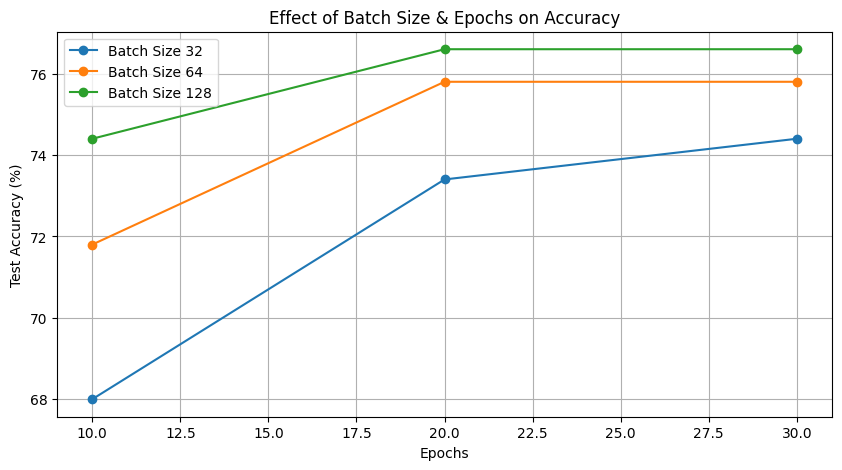

In [7]:
# Define the CNN model
def create_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # 10 classes
    ])
    return model

# Experiment settings
batch_sizes = [32, 64, 128]
epochs_list = [10, 20, 30]
results = {}

# Loop through batch size and epoch combinations
for batch in batch_sizes:
    for epoch in epochs_list:
        print(f"\nTraining with batch size {batch} and {epoch} epochs...\n")
        K.clear_session()

        model = create_model()
        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )


        history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epoch,
        batch_size=batch,
        verbose=0
        )

        test_loss, test_acc = model.evaluate(val_data, verbose=0)
        print(f"Test Accuracy with batch={batch}, epochs={epoch}: {test_acc * 100:.2f}%")
        results[(batch, epoch)] = test_acc

# Plot the results
plt.figure(figsize=(10, 5))
for batch in batch_sizes:
    accs = [results[(batch, epoch)] * 100 for epoch in epochs_list]
    plt.plot(epochs_list, accs, marker='o', linestyle='-', label=f'Batch Size {batch}')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.title('Effect of Batch Size & Epochs on Accuracy')
plt.legend()
plt.grid(True)
plt.show()


**Conclusion** From the experiment carried out with various batch-size-epoch combinations, it was noted that both batch size and epochs could have major implications on accuracy. As the batch size is increased from 32 to 128, test accuracy has an improving trend for all the epochs provided. Likewise, although performance usually improves with larger number of training epochs, after 20 epochs, the rates of improvement reduce. The best accuracy, 76.6%, was attained with batch size 128 and epochs in the 20 to 30 range. This seems to imply that, when combined with proper training epochs, a larger batch size facilitates the model learning better; however, increasing epochs after some point will yield very negligible improvements, which means diminishing returns.